# ENEL645 Final Project - Home Credit Default Risk
Author: *Group 20*

## Overview

We will go through a Kaggle project, the `Home Credit Default Risk`. In this project, we are going to follow the following workflow: 
1. Load, inspect and clean the data given in class by removing any features that might not be relevant for our models: `puzzle_train_dataset.csv` and `puzzle_test_dataset.csv`.
2. Preprocess and encode the data.
3. Train and find best model by applying hyperparameter tuning using grid search.
4. Retrain the best model on data and predict test data.

## Models to be Trained:
- Gradient Boosting Classifier
- RUSBoostClassifier (for imbalanced datasets)

## Import Libraries

In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Traditional ML library
import sklearn 
import sklearn.metrics as metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.ensemble import RUSBoostClassifier # ML for imbalanced problems
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

## 0. Function definitions

We will defined our own functions to make it easier to find the best model and hyperparameters that outputs the best accuracy scores for prediction.

In [2]:
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.
    
        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        
        scores are printed with 3 decimal places.
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        returns: None

    '''
    print("Best parameters: {}".format(grid_search.best_params_))
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

In [3]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        uses mglearn.tools.heatmap() for plotting.
        
    '''
    results = pd.DataFrame(grid_search.cv_results_)
    params = sorted(grid_search.param_grid.keys())
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [4]:
def get_encoder(df, col):
    dft = df[col].astype(str).to_frame().copy()
    dft["count"] = 1
    return dft.groupby(col).count().to_dict()["count"]
    
def encode_all(df_train, df_test, cols):
    for col in cols:
        enc = get_encoder(df_train, col)
        df_train[col] = df_train[col].astype(str).apply(lambda x: enc.get(x, -1))
        df_test[col] = df_test[col].astype(str).apply(lambda x: enc.get(x, -1))
    return df_train, df_test

## 1. Load, Inspect and Clean Data

In [5]:
# Features/columns to be removed for several reasons: ethical irrelevant feature, etc
to_remove = ["job_name", "reason","channel","n_issues","ok_since","zip","gender"] 

# Read train and test data and drop columns
df_train = pd.read_csv("puzzle_train_dataset.csv").set_index("ids").drop(to_remove, axis=1)
df_test = pd.read_csv("puzzle_test_dataset.csv").set_index("ids").drop(to_remove, axis=1)

print("Nb. of train samples: %d" %df_train.shape[0])
print("Number of test samples:  %d" %df_test.shape[0])
print("Nb. features: %d" %(df_train.shape[1]-1))

# Remove samples with missing labels
df_train = df_train[pd.notnull(df_train['default'])]
df_train["default"] = df_train["default"].astype("int")

print("Nb. of train samples after removing samples with no label: %d" %df_train.shape[0])
print("Classes ratio (False/True): %f" %((df_train["default"] == 0).sum()/(df_train["default"] == 1).sum()))

# Dataset information
feats_info = pd.concat([df_train.isnull().sum(), df_train.dtypes, df_train.T.apply(lambda x: x.nunique(), axis=1)], axis=1)
feats_info.columns = ["Missing","Type","Unique"]
print("\n Dataset Information (missing features, data type, unique values)")
print(feats_info)

Nb. of train samples: 64592
Number of test samples:  35000
Nb. features: 18
Nb. of train samples after removing samples with no label: 59966
Classes ratio (False/True): 5.305573

 Dataset Information (missing features, data type, unique values)
                    Missing     Type  Unique
default                   0    int32       2
score_1                   0   object       7
score_2                   0   object      35
score_3                   0  float64      87
score_4                   0  float64   59966
score_5                   0  float64   59966
score_6                   0  float64   59966
risk_rate                 0  float64      81
amount_borrowed           0  float64   50484
borrowed_in_months        0  float64       2
credit_limit          18779  float64   26238
income                    0  float64   54273
sign                  18938   object      12
facebook_profile       5971   object       2
state                     0   object      50
real_state                0   objec

## 2. Preprocess and Encode Data

In [6]:
# Create additional binary features flag for missing values for all features that have missing values
for col in df_test.columns:
    df_train["is_" + col + "_missing"] = df_train[col].isnull() * 1
    df_test["is_" + col + "_missing"] = df_test[col].isnull() * 1

# Represent categorical feature as a series o binary values and drop first column to avoid redundancy
df_train = pd.get_dummies(df_train, columns=['score_1','score_2','real_state'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['score_1','score_2','real_state'], drop_first=True)

encode_cols = df_train.dtypes
encode_cols = encode_cols[encode_cols == object].index.tolist()

# Encode categorical variables and replace NaN by -1
df_train, df_test = encode_all(df_train, df_test, encode_cols)
df_train, df_test = df_train.fillna(-1), df_test.fillna(-1)

# Split features and labels
X_train, y_train = df_train.drop(["default"], axis=1), df_train["default"]
X_test = df_test

In [7]:
# Print first rows of the training set
X_train.head()

,score_3,score_4,score_5,score_6,risk_rate,amount_borrowed,borrowed_in_months,credit_limit,income,sign,...,score_2_tHpS8e9F8d9zg3iOQM9tsA==,score_2_tQUTfUyeuGkhRotd+6WjVg==,score_2_vJyc9xom9v7hwFMPTIpmKw==,score_2_w1miZqhB5+RSamEQJa0rqg==,score_2_wjdj2vxjWoDsEIk0l09ynw==,score_2_wkeCdGeu5sEv4/fjwR0aDg==,real_state_N5/CE7lSkAfB04hVFFwllw==,real_state_UX7AdFYgQh+VrVC5eIaU9w==,real_state_n+xK9CfX0bCn77lClTWviw==,real_state_nSpvDsIsslUaX6GE6m6eQA==
ids,,,,,,,,,,,,,,,,,,,,,
810e3277-619e-3154-7ba0-ebddfc5f7ea9,710.0,104.174961,0.661509,123.015325,0.43,20024.31,60.0,62386.0,59869.05,5571,...,1,0,0,0,0,0,0,0,1,0
b4118fd5-77d5-4d80-3617-bacd7aaf1a88,330.0,97.880798,0.531115,110.913484,0.23,10046.51,36.0,-1.0,46016.31,1402,...,0,0,0,0,0,0,0,0,1,0
a75638f1-4662-4f4f-044a-d649b676d85d,360.0,97.908925,0.611086,104.620791,0.30,21228.25,60.0,-1.0,48025.47,5582,...,0,0,0,0,0,1,1,0,0,0
285ce334-3602-42b3-51cb-eebfcba48a09,120.0,100.434557,0.139784,120.134718,0.15,23032.33,36.0,-1.0,46011.12,18938,...,0,1,0,0,0,0,1,0,0,0
e643bf65-9288-92f2-df13-eed631fe237c,330.0,103.774638,0.002856,104.320462,0.08,24026.29,36.0,32366.0,90026.17,5582,...,0,0,0,0,0,0,1,0,0,0


In [8]:
# Print first rows of the test set
X_test.head()

,score_3,score_4,score_5,score_6,risk_rate,amount_borrowed,borrowed_in_months,credit_limit,income,sign,...,score_2_tHpS8e9F8d9zg3iOQM9tsA==,score_2_tQUTfUyeuGkhRotd+6WjVg==,score_2_vJyc9xom9v7hwFMPTIpmKw==,score_2_w1miZqhB5+RSamEQJa0rqg==,score_2_wjdj2vxjWoDsEIk0l09ynw==,score_2_wkeCdGeu5sEv4/fjwR0aDg==,real_state_N5/CE7lSkAfB04hVFFwllw==,real_state_UX7AdFYgQh+VrVC5eIaU9w==,real_state_n+xK9CfX0bCn77lClTWviw==,real_state_nSpvDsIsslUaX6GE6m6eQA==
ids,,,,,,,,,,,,,,,,,,,,,
e4366223-7aa2-0904-7a47-66479ae46b2a,230.0,101.906686,0.677760,77.245320,0.22,21016.38,36.0,43666.0,156021.02,18938,...,0,0,0,0,0,0,1,0,0,0
c6416108-c6d7-e6be-c4b5-923dd36c8ec4,400.0,96.276632,0.278711,94.980774,0.13,1211.74,36.0,-1.0,8410.56,1402,...,0,0,0,0,0,0,1,0,0,0
a90d3929-86ec-2414-89ba-543776b0e82b,420.0,98.901695,0.894661,108.136546,0.25,6990.63,36.0,-1.0,45116.60,3499,...,0,0,0,0,0,0,1,0,0,0
c5b96a7f-389a-28d0-242d-95db05e69da0,490.0,95.975994,0.972729,126.120768,0.46,15025.67,60.0,71273.0,60029.26,2839,...,0,0,0,0,0,0,0,0,1,0
1b461faa-926d-565d-b15d-0b452968ac81,320.0,101.303601,0.234202,107.162760,0.29,7027.81,36.0,-1.0,27618.96,3499,...,0,0,0,0,0,0,0,0,1,0


## 3. Train and Find Best Model - Hyperparameter Tuning

Since the data provided already has the training set and test set separate, we don't need to applied the `train_test_split` for this case.

### 3.1.a Grid Search for GradientBoostingClassifier 
We will perform hyperparameter tuning using `GridSearchCV` for the `GradientBoostingClassifier(max_depth=5, random_state=56)`. Grid search use 5-fold cross-validation, and `accuracy` as the scoring function.

The following hyperparameters and values are used:
- `'n_estimators': [30, 50, 100, 200]`,
- `'learning_rate': [0.001, 0.01, 0.1, 1.0]`

`print_grid_search_result()` and `plot_grid_search_result()` functions defined above will be used to show the results.

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [10, 30, 50, 100, 200],
              'learning_rate': [0.001, 0.01, 0.1, 1.0, 2.0]}

gbc = GradientBoostingClassifier(max_depth=5, random_state=56)
grid_search = GridSearchCV(gbc, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)
print_grid_search_result(grid_search)

Best parameters: {'learning_rate': 0.1, 'n_estimators': 50}
Best cross-validation score: 0.853


The use of `plot_grid_search_result()` function is to identify whether we are using bias values in our parameter grid. This allows us to go back and change any values needed within the parameter grid to yield the best accuracy score.

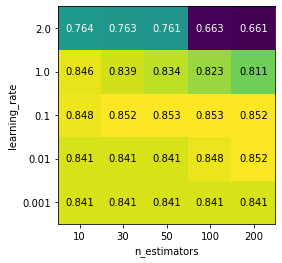

In [10]:
plot_grid_search_results(grid_search)

### 3.1.b Grid Search for RUSBoostClassifier

In [12]:
param_grid_rbc = {'n_estimators': [10, 30, 50, 100, 200],
                  'learning_rate': [0.001, 0.01, 0.1, 1.0, 2.0]}

rbc = RUSBoostClassifier(random_state=56)
grid_search_rbc = GridSearchCV(rbc, param_grid_rbc, cv=5, scoring='accuracy', return_train_score=True)
grid_search_rbc.fit(X_train, y_train)
print_grid_search_result(grid_search_rbc)

Best parameters: {'learning_rate': 0.1, 'n_estimators': 50}
Best cross-validation score: 0.728


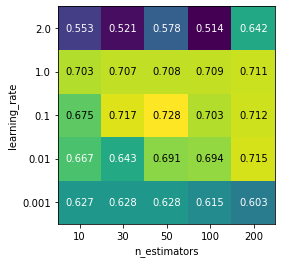

In [13]:
plot_grid_search_results(grid_search_rbc)

### 3.2.a Area Under the Curve with GradientBoostingClassifier

In [14]:
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, max_depth=5, random_state=56)
skf = StratifiedKFold(5, shuffle=True, random_state=100)
cm = np.zeros((2,2))
aucs = []

for (fold, (i_train, i_test)) in enumerate(skf.split(X_train, y_train)):
    gbc.fit(X_train.iloc[i_train], y_train.iloc[i_train])
    i_pred_proba = gbc.predict_proba(X_train.iloc[i_test])
    pred = gbc.predict(X_train.iloc[i_test])
    print(i_pred_proba.shape)
    auc = metrics.roc_auc_score(y_train.iloc[i_test], i_pred_proba[:, 1])
    aucs.append(auc)
    cm += metrics.confusion_matrix(y_train.iloc[i_test],pred)
    print("AUC score on fold %i: %2.3f" % (fold, auc))
    
print("\nAUC: %2.3f +- %2.4f" % (np.mean(aucs), np.std(aucs)))

(11994, 2)
AUC score on fold 0: 0.762
(11993, 2)
AUC score on fold 1: 0.766
(11993, 2)
AUC score on fold 2: 0.760
(11993, 2)
AUC score on fold 3: 0.771
(11993, 2)
AUC score on fold 4: 0.766

AUC: 0.765 +- 0.0036


### 3.2.b Area Under the Curve with RUSBoostClassifier

In [15]:
rbc = RUSBoostClassifier(learning_rate=0.1, n_estimators=50, random_state=56)
skf_rbc = StratifiedKFold(5, shuffle=True, random_state=100)
cm_rbc = np.zeros((2,2))
aucs_rbc = []

for (fold, (i_train, i_test)) in enumerate(skf_rbc.split(X_train, y_train)):
    rbc.fit(X_train.iloc[i_train], y_train.iloc[i_train])
    i_pred_proba = rbc.predict_proba(X_train.iloc[i_test])
    pred = rbc.predict(X_train.iloc[i_test])
    print(i_pred_proba.shape)
    auc = metrics.roc_auc_score(y_train.iloc[i_test], i_pred_proba[:, 1])
    aucs_rbc.append(auc)
    cm_rbc += metrics.confusion_matrix(y_train.iloc[i_test],pred)
    print("AUC score on fold %i: %2.3f" % (fold, auc))
    
print("\nAUC: %2.3f +- %2.4f" % (np.mean(aucs_rbc), np.std(aucs_rbc)))

(11994, 2)
AUC score on fold 0: 0.746
(11993, 2)
AUC score on fold 1: 0.749
(11993, 2)
AUC score on fold 2: 0.745
(11993, 2)
AUC score on fold 3: 0.754
(11993, 2)
AUC score on fold 4: 0.750

AUC: 0.749 +- 0.0034


### 3.3.a Confusion Matrix of GradientBoostingClassifier Model

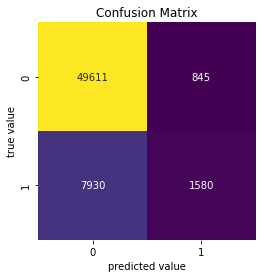

Accuracy = 0.854
Precision = 0.652
Recall = 0.166
F1-score = 0.265


In [40]:
sns.heatmap(cm, square=True, annot=True, cbar=False, fmt='g', cmap='viridis')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.title('Confusion Matrix')
plt.show()

TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

accuracy = (TP+TN)/(TP+TN+FN+FP)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy = %2.3f" %(cm.diagonal().sum()/cm.sum()))
print("Precision = %2.3f" %precision)
print("Recall = %2.3f" %recall)
print("F1-score = %2.3f" %f1)

### 3.3.b Confusion Matrix of RUSBoostClassifier Model

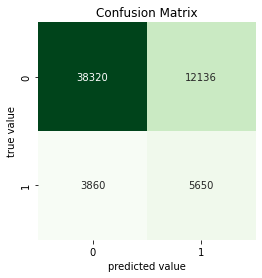

Accuracy = 0.733
Precision = 0.318
Recall = 0.594
F1-score = 0.414


In [41]:
sns.heatmap(cm_rbc, square=True, annot=True, cbar=False, fmt='g', cmap='Greens')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.title('Confusion Matrix')
plt.show()

TN = cm_rbc[0][0]
TP = cm_rbc[1][1]
FN = cm_rbc[1][0]
FP = cm_rbc[0][1]

accuracy = (TP+TN)/(TP+TN+FN+FP)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy = %2.3f" %(cm_rbc.diagonal().sum()/cm_rbc.sum()))
print("Precision = %2.3f" %precision)
print("Recall = %2.3f" %recall)
print("F1-score = %2.3f" %f1)

### 3.5.a Feature Importances of GradientBoostingClassifier

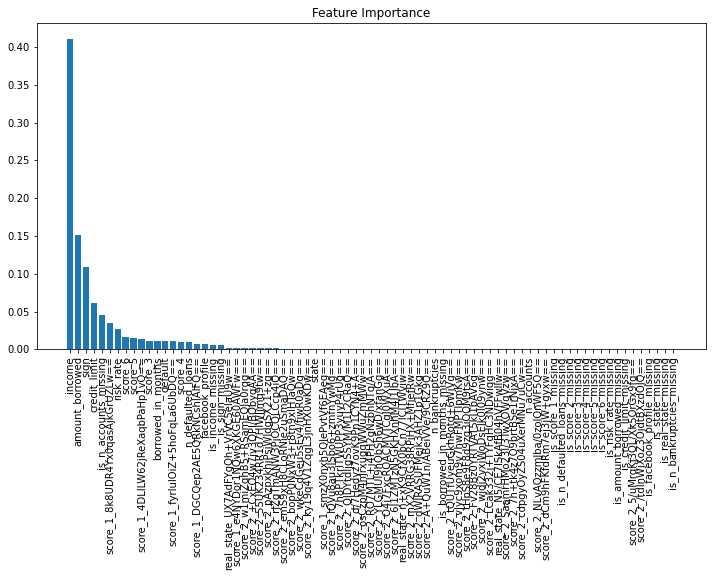

In [20]:
gbc.fit(X_train, y_train)
importances = gbc.feature_importances_

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, indices.size + 1), importances[indices], align="center")
plt.xticks(range(1, indices.size + 1),
           df_train.columns[indices],
           rotation=90)
plt.title("Feature Importance")
plt.show()

### 3.5.b Feature Importances of RUSBoostClassifier

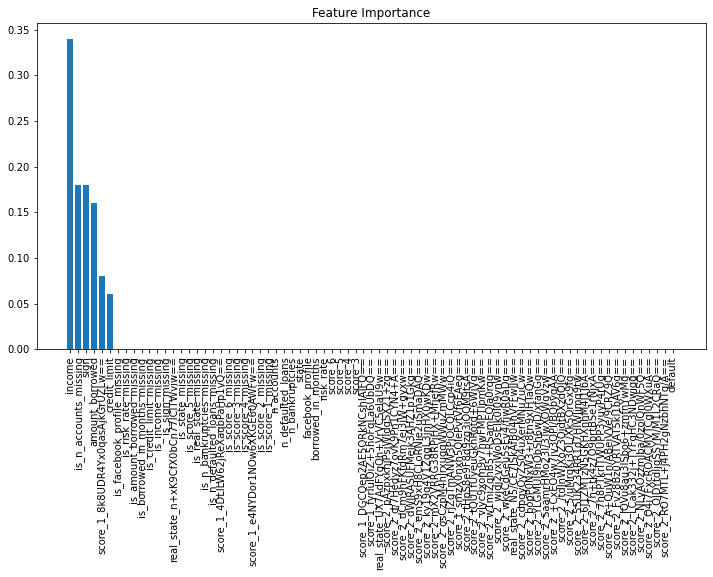

In [21]:
rbc.fit(X_train, y_train)
importances = rbc.feature_importances_

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, indices.size + 1), importances[indices], align="center")
plt.xticks(range(1, indices.size + 1),
           df_train.columns[indices],
           rotation=90)
plt.title("Feature Importance")
plt.show()

## 4. Retrain Best Model and Predict Test Data
The accuracy score is misleading for our particular problem. We would want to prevent lending money from customers that aren't able to pay back the loan, so we rather look at the model with the highest recall score instead. Based on the values seen in our confusion matrices and the model with the highest sens, it turns out that the `RUSBoostClassifier` with parameters: `{'learning_rate': 0.1, 'n_estimators': 50}` yields the best score of `59.4%` than the GradientBoostingClassifier which yields only a 16.6% in recall. Let's retrain the training dataset with the best model and its hyperparameters.

In [ ]:
rbc.fit(X_train, y_train)
my_predictions = pd.DataFrame(rbc.predict_proba(X_test)[:, 1], columns=["predictions"], index=X_test.index)
my_predictions.to_csv("rbc_predictions.csv")
my_predictions

,predictions
ids,
e4366223-7aa2-0904-7a47-66479ae46b2a,0.482598
c6416108-c6d7-e6be-c4b5-923dd36c8ec4,0.520981
a90d3929-86ec-2414-89ba-543776b0e82b,0.485926
c5b96a7f-389a-28d0-242d-95db05e69da0,0.552575
1b461faa-926d-565d-b15d-0b452968ac81,0.498102
...,...
cfe269ae-b893-c084-f9f5-3b91f9725b71,0.493307
2feff27a-3dcf-1e19-7583-a8eab192fd23,0.467233
601509fd-20d9-d3b8-b143-defcf5457d2c,0.503991
